### Installing and loading libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
from plot_functions import mara_3Dplot, plotly_viz

In [3]:
distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']
distinct_colors_14 = ['#ffffff', 
                      '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                      '#911eb4', '#46f0f0', '#f032e6', '#fffac8', 
                      '#008080', '#e6beff', '#9a6324', '#000000', '#aaffc3']

In [4]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures", "clustering")

if (not os.path.isdir(FIGURES)):
    os.mkdir(FIGURES)
    print("Generated directory at: ",FIGURES)
else:
    print("Directory already present")

Directory already present


In [5]:
dftype = "reduced"

spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, 'df_focal_'+dftype+'.pkl'))
embedding_filename = 'basic_UMAP_3D_'+dftype+'_default_params.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

Setting project, input and output folders.

# Clustering

In [9]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import AffinityPropagation

In [10]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import scipy
#os.system('pip install scikit-fuzzy')
#import skfuzzy as fuzz

In [11]:
# https://stackoverflow.com/questions/49586742/rand-index-function-clustering-performance-evaluation

def rand_index_score(clusters, classes):
    tp_plus_fp = scipy.special.comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
    
def calc_rand(pred, true):
    classnames, pred = np.unique(pred, return_inverse=True)
    classnames, true = np.unique(true, return_inverse=True)
    return rand_index_score(pred, true)

Brief overview of some clustering methods:
https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods

Or:
https://hdbscan.readthedocs.io/en/0.8.6/comparing_clustering_algorithms.html

The aim is to cluster the calls into distinct categories based on the UMAP values. I'm also adding duration as a third variable, since it looks like it would really improve clustering.
I try different clustering methods and compare their performance using several evaluation metrics.

In [12]:
true_labels = spec_df.call_lable.values
cluster_df = pd.DataFrame(embedding)

In [13]:
N_CLUST = 7
cluster_df.head(3)

,0,1,2
0,1.024931,-0.010566,7.555627
1,0.723105,0.308873,7.613667
2,2.005775,1.012433,7.020350


In [42]:
clusterings_dict = {}

In [43]:
clusterings_dict['Spectral'] = SpectralClustering(random_state=2204).fit(embedding).labels_

HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=int(0.01*embedding.shape[0]),cluster_selection_method = 'leaf').fit(embedding)

clusterings_dict['HDBSCAN'] = HDBSCAN.labels_
clusterings_dict['Kmeans'] = KMeans(n_clusters=N_CLUST, random_state=2204).fit(embedding).labels_
clusterings_dict['Agglomerative'] = AgglomerativeClustering(n_clusters=N_CLUST).fit(embedding).labels_
clusterings_dict['GaussianMixture'] = BayesianGaussianMixture(n_components=N_CLUST).fit(embedding).predict(embedding)


# also create HDBSCAN without noise
cluster_labels = clusterings_dict['HDBSCAN'].copy()

assigned = np.full((len(cluster_labels),), False)
assigned[np.where(cluster_labels!=-1)[0]] = True
clusterings_dict['HDBSCAN-no-noise'] = cluster_labels[assigned] 
df_hdb = spec_df.loc[assigned]
embedding_hdb = embedding[assigned,:]

In [44]:
eval_params = ['rand', 'adj_rand', 'SIL', 'n_clusters']

cluster_eval = pd.DataFrame(np.zeros((len(clusterings_dict.keys()), len(eval_params))), index=list(clusterings_dict.keys()), 
                            columns=eval_params)
print(cluster_eval.shape)
truth_var = 'call_lable'

for cluster_method in clusterings_dict.keys():
#for cluster_method in ['HDBSCAN-no-noise']:
    print(cluster_method)
    
    outname = os.path.join(os.path.sep, FIGURES, cluster_method+'_'+dftype+'.jpg')
    cluster_labels = clusterings_dict[cluster_method]
    

    if cluster_method == "HDBSCAN-no-noise":
        df = df_hdb
        true_labels = df.call_lable.values
        embedding_data = embedding_hdb
    else:
        df = spec_df
        true_labels = df.call_lable.values
        embedding_data = embedding
        mycolors = distinct_colors_22
    
    # color noise (always class -1) in grey (only applied so HDBSCAN)
    mycolors = distinct_colors_22 if not cluster_method=="HDBSCAN" else ['#d9d9d9'] + distinct_colors_22
    
    # generate plot 
    print(outname)
    mara_3Dplot(embedding_data[:,0],
               embedding_data[:,1],
               embedding_data[:,2],
               cluster_labels,
               mycolors,
               outname = outname)
    plt.close()
               
    
    # evaluate clustering         
    cluster_eval.loc[cluster_method, 'rand'] = calc_rand(cluster_labels, true_labels)
    cluster_eval.loc[cluster_method, 'adj_rand'] = adjusted_rand_score(cluster_labels, true_labels)
    cluster_eval.loc[cluster_method, 'SIL'] = silhouette_score(embedding_data, cluster_labels)
    cluster_eval.loc[cluster_method, 'n_clusters'] = len(list(set(cluster_labels)))
  
    
    # plot cluster content vs. ground truth 
    cluster_labeltypes = sorted(list(set(cluster_labels)))
    true_labeltypes = sorted(list(set(true_labels)))
    
    stats_tab = np.zeros((len(cluster_labeltypes), len(true_labeltypes)))
    
    for i,clusterlabel in enumerate(cluster_labeltypes):
        label_df = df.loc[cluster_labels==clusterlabel]
        for j, truelabel in enumerate(true_labeltypes):
            stats_tab[i,j] = sum(label_df[truth_var]==truelabel)
    
    # rowsums
    stats_tab_norm = np.zeros((stats_tab.shape))
    rowsums = np.sum(stats_tab, axis=1)
    for i in range(stats_tab.shape[0]):
        stats_tab_norm[i,:] = stats_tab[i,:]/rowsums[i]
    
    stats_tab = pd.DataFrame(stats_tab, index=cluster_labeltypes, columns=true_labeltypes)
    stats_tab_norm = pd.DataFrame(stats_tab_norm, index=cluster_labeltypes, columns=true_labeltypes) * 100
    
    outname = os.path.join(os.path.sep, FIGURES, 'heatnorm_'+cluster_method+'_'+dftype+'.jpg')
    ax = sns.heatmap(stats_tab_norm, annot=True, cmap='viridis', fmt='.1f', cbar=False)
    plt.xlabel("Manual label")
    plt.ylabel("Cluster label")
    plt.savefig(outname)
    plt.close()
    
    outname = os.path.join(os.path.sep, FIGURES, 'heat_'+cluster_method+'_'+dftype+'.jpg')
    ax = sns.heatmap(stats_tab.astype(int), annot=True, cmap='viridis', fmt='d', cbar=False)
    plt.xlabel("Manual Label")
    plt.ylabel("Cluster Label")
    plt.savefig(outname)
    plt.close()  

(6, 4)
Spectral
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/Spectral_reduced.jpg
HDBSCAN
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/HDBSCAN_reduced.jpg
Kmeans
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/Kmeans_reduced.jpg
Agglomerative
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/Agglomerative_reduced.jpg
GaussianMixture
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/GaussianMixture_reduced.jpg
HDBSCAN-no-noise
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/HDBSCAN-no-noise_reduced.jpg


In [54]:
cluster_eval

,rand,adj_rand,SIL,n_clusters
Spectral,0.814589,0.340468,0.448579,8.0
HDBSCAN,0.675096,0.092908,-0.107416,15.0
Kmeans,0.807735,0.328739,0.468933,7.0
Agglomerative,0.810296,0.366630,0.457524,7.0
GaussianMixture,0.816174,0.357665,0.411623,7.0
HDBSCAN-no-noise,0.859703,0.459668,0.508198,14.0


## HDBSCAN

This is the clustering algorithm that was used in the paper. It's basically a hierarchical clustering algorithm, but the distance matrix is built from the "mutual reachability distance" (distances in sparser regions become larger). In addition, the decision on where to "cut the tree" is based on an evaluation metric. Points can "fall out of clusters" and thus be left unassigned (these are then labelled with -1).

More detailed explanation: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

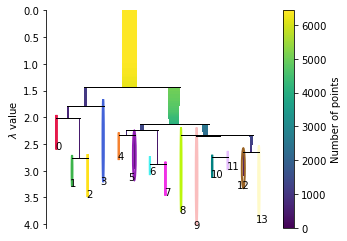

In [49]:
#  tree plot

fig = plt.figure(figsize=(5,4))
labeltypes = sorted(list(set(HDBSCAN.labels_)))
customPalette = sns.color_palette(distinct_colors_22, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

HDBSCAN.condensed_tree_.plot(select_clusters=True,
                             selection_palette=customPalette,
                             label_clusters = True
                            )
plt.savefig(os.path.join(os.path.sep,FIGURES,'HDBSCAN_treeplot_small.png'), facecolor="white")

In [48]:
os.path.join(os.path.sep,FIGURES,'HDBSCAN_treeplot.png')

'/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/HDBSCAN_treeplot.png'

In [52]:
pd.Series(HDBSCAN.labels_).value_counts()

-1     3138
 12     628
 5      583
 7      346
 13     299
 0      271
 6      199
 2      173
 9      155
 11     137
 3      134
 10     100
 1       99
 4       96
 8       72
dtype: int64

In [60]:
(os.path.join(os.path.sep,FIGURES,'HDBSCAN_cluster_examples.png'))

'/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/HDBSCAN_cluster_examples.png'

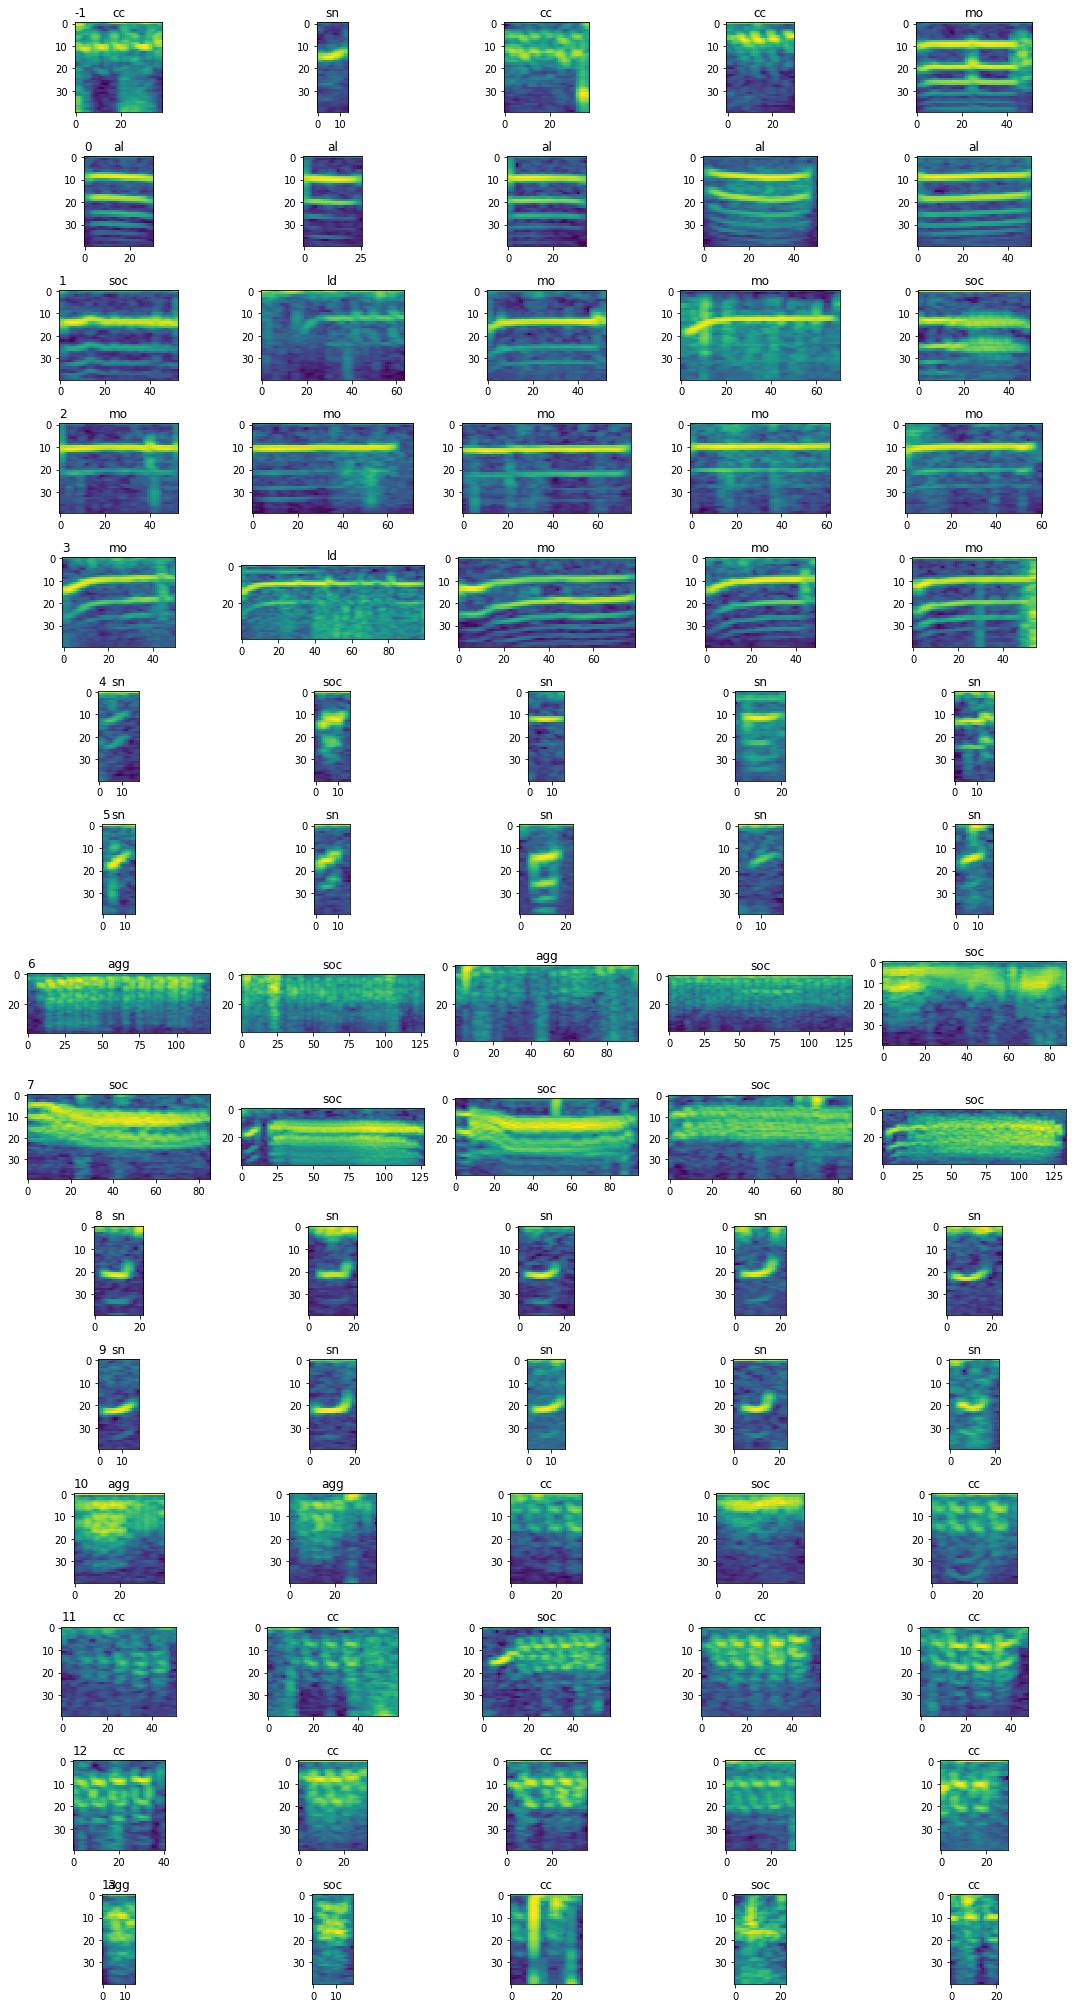

In [62]:
# EXAMPLE SPECS

n_specs=5
specs = {}
  
plt.figure(figsize=(15, 28))
spec_df['HDBSCAN'] = HDBSCAN.labels_
clusters = sorted(list(set(spec_df.HDBSCAN.values)))
k=1

for cluster in clusters:
    example = spec_df[spec_df['HDBSCAN']==cluster].sample(n = n_specs, random_state=1234)
    specs = example['spectrograms'].values
    labels = example['call_lable'].values
    i=0 
    for spec, label in zip(specs, labels):
        plt.subplot(len(clusters), n_specs, k)
        plt.imshow(spec, interpolation='nearest', aspect='equal')
        if i==0:     
            title = str(cluster)
            plt.title(title, loc='left')
            title = str(label)
            plt.title(title)
        else:
            title = str(label)
            plt.title(title)
    
    #title = str(cluster)+" ("+str(label)+")"
    #title = str(label)
        k += 1
        i+=1
plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES,'HDBSCAN_cluster_examples.png'), facecolor="white")

In addition to unassigned data, there's also outliers:

## Find optimal n_clusters

In [18]:
cluster_methods = ['Kmeans', 'Agglomerative', 'GMM']

In [19]:
def kmeans_labels(n, embdding):
    return KMeans(n_clusters=n, random_state=2204).fit(embedding).labels_

def aggl_labels(n, embedding):
    return AgglomerativeClustering(n_clusters=n).fit(embedding).labels_

def gmm_labels(n, embedding):
    return BayesianGaussianMixture(n_components=n).fit(embedding).predict(embedding)

get_labels = {
    'Kmeans': kmeans_labels,
    'Agglomerative': aggl_labels,
    'GMM': gmm_labels}

In [20]:
max_clusters = 25
eval_dict = {}

for cluster_method in cluster_methods:
    eval_df = np.zeros((max_clusters,4))   
    for n_clust in range(1,max_clusters+1):
        pred = get_labels[cluster_method](n_clust, embedding)
        eval_df[n_clust-1,0] = n_clust
        eval_df[n_clust-1,1] = adjusted_rand_score(pred, true_labels)
        eval_df[n_clust-1,2] = calc_rand(pred, true_labels)
        if n_clust>1:
            eval_df[n_clust-1,3] = silhouette_score(np.asarray(embedding), pred)
    eval[cluster_method] = eval_df

/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did n

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/opti_n_clust_Kmeans.png


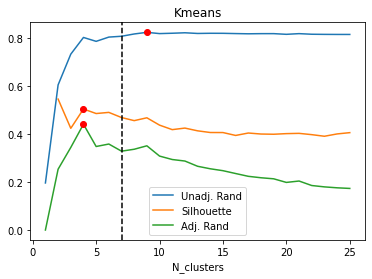

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/opti_n_clust_Agglomerative.png


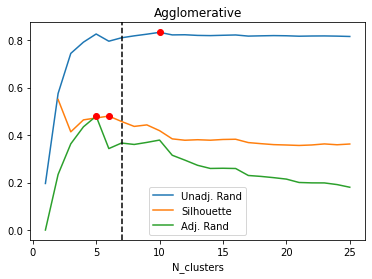

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/clustering/opti_n_clust_GMM.png


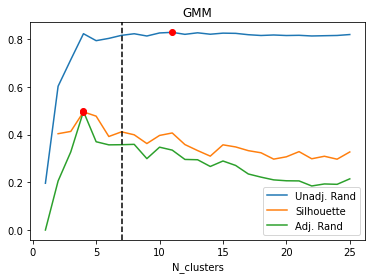

In [21]:
# Plot evaluation metrics for different n_clusters

for cluster_method in cluster_methods:
    eval_df = eval_dict[cluster_method]
    x = eval_df[:,0]
    plt.plot(x,eval_df[:,2], label='Unadj. Rand')
    plt.plot(x[1:],eval_df[1:,3], label='Silhouette')
    plt.plot(x, eval_df[:,1], label='Adj. Rand')

    # Add maximums
    maxi = np.where(eval_df[:,2]==np.max(eval_df[:,2]))[0][0]
    plt.plot(maxi+1, eval_df[maxi,2], 'ro')

    maxi = np.where(eval_df[:,3]==np.max(eval_df[2:,3]))[0][0]
    plt.plot(maxi+1, eval_df[maxi,3], 'ro')

    maxi = np.where(eval_df[:,1]==np.max(eval_df[:,1]))[0][0]
    plt.plot(maxi+1, eval_df[maxi,1], 'ro')

    plt.xlabel("N_clusters")
    plt.axvline(x=7, color="black", linestyle='--')
    plt.legend()
    plt.title(cluster_method)
    outname = os.path.join(os.path.sep,FIGURES, 'opti_n_clust_'+cluster_method+'.png')
    print(outname)
    plt.savefig(outname)
    plt.show()
    plt.close()

In [25]:
eval_dict = eval
kmeans_eval = eval['Kmeans']

for cluster_method in cluster_methods:
    df_eval = eval_dict[cluster_method]
    print(cluster_method)
    print("Adj:",round(np.min(df_eval[:,1]),2),"-",round(np.max(df_eval[:,1]),2), " max: ", np.where(df_eval[:,1]==np.max(df_eval[:,1]))[0][0]+1)
    print("Unaddj:",round(np.min(df_eval[:,2]),2),"-",round(np.max(df_eval[:,2]),2), " max: ", np.where(df_eval[:,2]==np.max(df_eval[:,2]))[0][0]+1)
    print("Sil>3:",round(np.min(df_eval[2:,3]),2),"-",round(np.max(df_eval[2:,3]),2), " max: ", np.where(df_eval[:,3]==np.max(df_eval[2:,3]))[0][0]+1)

Kmeans
Adj: 0.0 - 0.44  max:  4
Unaddj: 0.2 - 0.82  max:  9
Sil>3: 0.39 - 0.5  max:  4
Agglomerative
Adj: 0.0 - 0.48  max:  5
Unaddj: 0.2 - 0.83  max:  10
Sil>3: 0.36 - 0.48  max:  6
GMM
Adj: 0.0 - 0.5  max:  4
Unaddj: 0.2 - 0.83  max:  11
Sil>3: 0.3 - 0.5  max:  4


### Adjusted mutual information score

In [ ]:
for cl in clusterings.keys():
  if(cl=="HDBSCAN"):
    print(cl,"(w/o -1):", adjusted_rand_score(HDB_pred_labels, HDB_true_labels))
  print(cl,":", metrics.adjusted_mutual_info_score(clusterings[cl].labels_, true_labels))

HDBSCAN (w/o -1): 0.034588635805066895
HDBSCAN : 0.13731435714579082
KMeans : 0.3702432232471313
Aggl_Euclid : 0.3647816882537414


In [ ]:
metrics.adjusted_mutual_info_score(aggl_clusterer.labels_, true_labels)

0.3488966391981895

### Compare against random
Just to double-check

In [ ]:
random_assignment = np.random.randint(0, 8, size=(len(true_labels), ))

In [ ]:
for cl in clusterings.keys():
  print(cl,":", adjusted_rand_score(clusterings[cl].labels_, random_assignment))
for cl in clusterings.keys():
  print(cl,":", metrics.adjusted_mutual_info_score(clusterings[cl].labels_, random_assignment))

HDBSCAN : -0.00148735995588718
KMeans : 0.000952395976263719
Aggl_Euclid : -0.00028964932218638635
Aggl_City : 0.00014366126949008845
Aggl_Ward : 0.0014041331031844487
HDBSCAN : -0.002069436590455159
KMeans : 0.0012514822718355304
Aggl_Euclid : -2.366572680243078e-05
Aggl_City : 0.00022876840970089717
Aggl_Ward : 0.0019151573455251552


Do the resulting clusters reflect other features than call type? Individual maybe? Sex? Status?

## Assign clusters to ground truth label groups

In [ ]:
meerkat_info

,Name,DOB,Code,Dye mark,Sex,Status
0,FLINT LOCKWOOD,27.10.16,VHMF001,H + TB,F,Dominant
1,PET,21.12.11,VCVM001,H + MB,M,Dominant
2,DANTE,27-29.12.2016,VHMM007,LS + LT,M,Eldest Subordinate
3,GUACAMOLE,01.09.17,VHMM008,SH + TB,M,Adult
4,DOUBLE FLUFF,01.09.17,VHMF010,SH + LT,F,Eldest Subordinate
5,TWIRL,15.05.18,VHMM014,LS + TB,M,Yearling
6,MOZARELLA,15.05.18,VHMF015,RT + TB,F,Yearling
7,OSCAR JUNIOR,15.05.18,VHMM016,LT + TB,M,Yearling
8,PINGU,15.05.18,VHMM017,RS + TB,M,Yearling
9,MUNCHKIN,26.09.18,VHMF019,MB + TB,F,Subadult


In [ ]:
meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match +
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

In [ ]:
for ind in sorted(list(set(umap_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
      #  meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "appears to be ", ind_code) # this is sometimes wrong!
    else:
      print(ind, "not in dyemarks")

HMB appears to be  VCVM001
HRT not in dyemarks
HTB appears to be  VHMF001
LT appears to be  VHMF031
PET not in dyemarks
RT appears to be  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['HMB'] = meerkat_dict['VCVM001']
meerkat_dict['HTB'] = meerkat_dict['VHMF001']
meerkat_dict['LT'] = meerkat_dict['VHMM007'] # Ari told me this and it's in "audio_labeling_summary.xlsx"


#meerkat_dict['RT'] = meerkat_dict['VHMM006'] # COSMO, Ari told me this. VHMM006 is not in the file though!!! But I don't know his age/sex etc. 
                                             # I can find DOB in "GroupMarkJune2017.xls" and I guess it's a male. 
meerkat_dict['RT'] = {'DOB': '28.12.2016', 
                          'Dye mark': 'RT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }                                            

In [ ]:
meerkat_dict['HTB']

{'DOB': '27.10.16', 'Dye mark': 'HTB', 'Sex': 'F', 'Status': 'Dominant'}

Remaining:

- HRT not in dyemarks
- PET not in dyemarks
- VHMM002 not in dyemarks
- VHMM003 not in dyemarks
- VLF206 not in dyemarks

PET is a name and has code VCVM001 :

In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']

VLF206 info can be found in add. excel:

In [ ]:
meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }

VHMM002 and VHMM003 can be found in additional excel sheets. Status and birth are just guesses. HRT is VHMM002.

In [ ]:
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Subordinate'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }

meerkat_dict['HRT'] = meerkat_dict['VHMM002'] 

Remainders will be set to "unknown"

In [ ]:
for ind in sorted(list(set(umap_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'unknown', 
                         'Dye mark': 'unknown', 
                         'Sex': 'unknown', 
                         'Status':'unknown'}

In [ ]:
meerkat_dict

{'HMB': {'DOB': '21.12.11',
  'Dye mark': 'HMB',
  'Sex': 'M',
  'Status': 'Dominant'},
 'HRT': {'DOB': '27.10.16',
  'Dye mark': 'HRT',
  'Sex': 'M',
  'Status': 'Subordinate'},
 'HTB': {'DOB': '27.10.16',
  'Dye mark': 'HTB',
  'Sex': 'F',
  'Status': 'Dominant'},
 'LT': {'DOB': '27-29.12.2016',
  'Dye mark': 'LSLT',
  'Sex': 'M',
  'Status': 'Eldest Subordinate'},
 'PET': {'DOB': '21.12.11',
  'Dye mark': 'HMB',
  'Sex': 'M',
  'Status': 'Dominant'},
 'RT': {'DOB': '28.12.2016', 'Dye mark': 'RT', 'Sex': 'M', 'Status': 'Adult'},
 'VCVM001': {'DOB': '21.12.11',
  'Dye mark': 'HMB',
  'Sex': 'M',
  'Status': 'Dominant'},
 'VHMF001': {'DOB': '27.10.16',
  'Dye mark': 'HTB',
  'Sex': 'F',
  'Status': 'Dominant'},
 'VHMF010': {'DOB': '01.09.17',
  'Dye mark': 'SHLT',
  'Sex': 'F',
  'Status': 'Eldest Subordinate'},
 'VHMF015': {'DOB': '15.05.18',
  'Dye mark': 'RTTB',
  'Sex': 'F',
  'Status': 'Yearling'},
 'VHMF019': {'DOB': '26.09.18',
  'Dye mark': 'MBTB',
  'Sex': 'F',
  'Status': 'Su

## Adding metadata columns

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in umap_df['indv']]
umap_df['Sex'] = sex

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
status = [meerkat_dict[ind]['Status'] for ind in umap_df['indv']]
umap_df['status'] = status

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now solve the tricky situation with VHMF001 / HTB, who was a subordinate in 2017, but dominant in 2019.

In [ ]:
print(meerkat_dict['HTB'])
print(meerkat_dict['VHMF001'])

{'DOB': '27.10.16', 'Dye mark': 'HTB', 'Sex': 'F', 'Status': 'Dominant'}
{'DOB': '27.10.16', 'Dye mark': 'HTB', 'Sex': 'F', 'Status': 'Dominant'}


For now, all are labeled as dominant. So, have to select those rows of HTB or VHMF001 that were recorded in 2017 and change status to 2017 there.

In [ ]:
umap_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,Sex,status
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,M,Dominant
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,M,Dominant
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,M,Dominant


In [ ]:
# extract date 
year = [str.split(x, sep='-')[0] for x in umap_df['date']]
umap_df['year'] = year

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
umap_df.loc[(umap_df['indv'] == 'VHMF001') & (umap_df['year'] == '2017')]

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,Sex,status,year
24447,SN,1:09:47.294,0:00.059,decimal,Cue,NaN,y,4187.294,0.059,4187.353,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,66,sn,"[-0.005859375, 0.0078125, -0.009765625, 0.0039...","[[-9.12034, -7.8342533, -6.9505873, -8.379859,...","[[-243.9419, -232.68925, -209.43353, -192.5054...","[[10.176844, 10.176844, 10.176844, 10.176844, ...","[[-2.7138033, -2.7138033, -2.7138033, -2.71380...",n,"[[-12.621922, -17.376266, -18.933643, -11.8097...","[[-368.53745, -328.14212, -313.5418, -287.8001...","[[8.732509, 8.732509, 8.732509, 8.732509, 8.73...","[[-5.279335, -5.279335, -5.279335, -5.279335, ...","[[30.859049, 29.871244, 28.086262, 24.88847, 2...","[[48.354904, 37.238087, 31.938965, 34.994816, ...","[[8.909963, 5.781242, 12.158962, 17.901949, 22...","[[17.113825, 17.269373, 8.204816, 8.217686, 8....","[[1.5314395, 1.5314395, 1.5314395, 1.5314395, ...","[[-2.012412, -2.012412, -2.012412, -2.012412, ...",y,24447,n,F,Dominant,2017
24448,SN,1:09:47.995,0:00.053,decimal,Cue,NaN,y,4187.995,0.053,4188.048,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,67,sn,"[-0.044921875, -0.046875, -0.044921875, -0.035...","[[-12.605859, -12.539427, -12.698671, -12.3272...","[[-240.92181, -231.70934, -223.08461, -219.113...","[[3.8715873, 3.8715873, 3.8715873, 3.8715873, ...","[[-0.5800178, -0.5800178, -0.5800178, -0.58001...",n,"[[-28.960033, -28.844135, -27.78786, -26.71758...","[[-359.80817, -328.37265, -294.0607, -285.1463...","[[7.5880647, 7.5880647, 7.5880647, 7.5880647, ...","[[-4.119387, -4.119387, -4.119387, -4.119387, ...","[[27.752106, 26.677874, 25.188536, 25.885962, ...","[[27.61892, 25.775295, 20.634754, 18.744778, 2...","[[14.324346, 16.322618, 16.535116, 22.568087, ...","[[-1.9714499, 17.070961, 12.190815, 2.382884, ...","[[-2.8002315, -2.8002315, -2.8002315, -2.80023...","[[-0.7711636, -0.7711636, -0.7711636, -0.77116...",y,24448,n,F,Dominant,2017
24450,LD,1:09:49.484,0:00.172,decimal,Cue,NaN,y,4189.484,0.172,4189.656,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,69,ld,"[0.072265625, 0.048828125, 0.0390625, 0.041015...","[[-3.1968317, -2.0130405, -0.36056137, 0.0, -1...","[[-111.823235, -95.08124, -75.8278, -63.911022...","[[2.0079691, 2.0079691, 2.0079691, 2.0079691, ...","[[-5.1472526, -5.1472526, -5.1472526, -5.14725...",n,"[[-5.2031174, -6.430584, -5.95595, -1.4454632,...","[[-183.6088, -164.08186, -149.9257, -103.47158...","[[11.008109, 11.008109, 11.008109, 11.008109, ...","[[-4.9522457, -4.9522457, -4.9522457, -4.95224...","[[15.101289, 13.446242, 11.782511, 10.508072, ...","[[22.049206, 18.277681, 17.407272, 14.59622, 1...","[[3.9042406, 2.691847, 0.9717282, 2.5478597, 4...","[[-11.249973, -7.813058, -2.16372, -2.0150666,...","[[-0.5437218, -0.5437218, -0.5437218, -0.54372...","[[1.047911, 1.047911, 1.047911, 1.047911, 1.04...",y,24450,n,F,Dominant,2017
24451,LD,1:09:49.999,0:00.216,decimal,Cue,NaN,y,4189.999,0.216,4190.215,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,70,ld,"[-0.21875, -0.24804688, -0.26953125, -0.300781...","[[-4.5283446, -3.5543823, -2.9191787, -4.24102...","[[-178.6896, -184.77333, -203.80704, -232.0680...","[[-2.0341754, -2.0341754, -2.0341754, -2.03417...","[[5.1797705, 5.1797705, 5.1797705, 5.1797705, ...",n,"[[-8.749271, -10.6373005, -10.44066, -3.066684...","[[-350.00497, -287.60394, -245.94174, -204.995...","[[7.5400095, 7.5400095, 7.5400095, 7.5400095, ...","[[-13.145781, -13.145781, -13.145781, -13.1457...","[

In [ ]:
umap_df.loc[(umap_df['indv'] == 'VHMF001') & (umap_df['year'] == '2017'),'status'] = 'Subordinate'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
umap_df.loc[(umap_df['indv'] == 'VHMF001') & (umap_df['year'] == '2017')]

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,Sex,status,year
24447,SN,1:09:47.294,0:00.059,decimal,Cue,NaN,y,4187.294,0.059,4187.353,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,66,sn,"[-0.005859375, 0.0078125, -0.009765625, 0.0039...","[[-9.12034, -7.8342533, -6.9505873, -8.379859,...","[[-243.9419, -232.68925, -209.43353, -192.5054...","[[10.176844, 10.176844, 10.176844, 10.176844, ...","[[-2.7138033, -2.7138033, -2.7138033, -2.71380...",n,"[[-12.621922, -17.376266, -18.933643, -11.8097...","[[-368.53745, -328.14212, -313.5418, -287.8001...","[[8.732509, 8.732509, 8.732509, 8.732509, 8.73...","[[-5.279335, -5.279335, -5.279335, -5.279335, ...","[[30.859049, 29.871244, 28.086262, 24.88847, 2...","[[48.354904, 37.238087, 31.938965, 34.994816, ...","[[8.909963, 5.781242, 12.158962, 17.901949, 22...","[[17.113825, 17.269373, 8.204816, 8.217686, 8....","[[1.5314395, 1.5314395, 1.5314395, 1.5314395, ...","[[-2.012412, -2.012412, -2.012412, -2.012412, ...",y,24447,n,F,Subordinate,2017
24448,SN,1:09:47.995,0:00.053,decimal,Cue,NaN,y,4187.995,0.053,4188.048,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,67,sn,"[-0.044921875, -0.046875, -0.044921875, -0.035...","[[-12.605859, -12.539427, -12.698671, -12.3272...","[[-240.92181, -231.70934, -223.08461, -219.113...","[[3.8715873, 3.8715873, 3.8715873, 3.8715873, ...","[[-0.5800178, -0.5800178, -0.5800178, -0.58001...",n,"[[-28.960033, -28.844135, -27.78786, -26.71758...","[[-359.80817, -328.37265, -294.0607, -285.1463...","[[7.5880647, 7.5880647, 7.5880647, 7.5880647, ...","[[-4.119387, -4.119387, -4.119387, -4.119387, ...","[[27.752106, 26.677874, 25.188536, 25.885962, ...","[[27.61892, 25.775295, 20.634754, 18.744778, 2...","[[14.324346, 16.322618, 16.535116, 22.568087, ...","[[-1.9714499, 17.070961, 12.190815, 2.382884, ...","[[-2.8002315, -2.8002315, -2.8002315, -2.80023...","[[-0.7711636, -0.7711636, -0.7711636, -0.77116...",y,24448,n,F,Subordinate,2017
24450,LD,1:09:49.484,0:00.172,decimal,Cue,NaN,y,4189.484,0.172,4189.656,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,69,ld,"[0.072265625, 0.048828125, 0.0390625, 0.041015...","[[-3.1968317, -2.0130405, -0.36056137, 0.0, -1...","[[-111.823235, -95.08124, -75.8278, -63.911022...","[[2.0079691, 2.0079691, 2.0079691, 2.0079691, ...","[[-5.1472526, -5.1472526, -5.1472526, -5.14725...",n,"[[-5.2031174, -6.430584, -5.95595, -1.4454632,...","[[-183.6088, -164.08186, -149.9257, -103.47158...","[[11.008109, 11.008109, 11.008109, 11.008109, ...","[[-4.9522457, -4.9522457, -4.9522457, -4.95224...","[[15.101289, 13.446242, 11.782511, 10.508072, ...","[[22.049206, 18.277681, 17.407272, 14.59622, 1...","[[3.9042406, 2.691847, 0.9717282, 2.5478597, 4...","[[-11.249973, -7.813058, -2.16372, -2.0150666,...","[[-0.5437218, -0.5437218, -0.5437218, -0.54372...","[[1.047911, 1.047911, 1.047911, 1.047911, 1.04...",y,24450,n,F,Subordinate,2017
24451,LD,1:09:49.999,0:00.216,decimal,Cue,NaN,y,4189.999,0.216,4190.215,2017-08-06,8000,VHMF001,/content/drive/My Drive/meerkat/in_wavs/HM_VHM...,70,ld,"[-0.21875, -0.24804688, -0.26953125, -0.300781...","[[-4.5283446, -3.5543823, -2.9191787, -4.24102...","[[-178.6896, -184.77333, -203.80704, -232.0680...","[[-2.0341754, -2.0341754, -2.0341754, -2.03417...","[[5.1797705, 5.1797705, 5.1797705, 5.1797705, ...",n,"[[-8.749271, -10.6373005, -10.44066, -3.066684...","[[-350.00497, -287.60394, -245.94174, -204.995...","[[7.5400095, 7.5400095, 7.5400095, 7.5400095, ...","[[-13.145781, -13.145781, -13.145781, -13.14

## Test

In [ ]:
np.arange(-1,14,1)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

Compare each cluster against full dataset: (Enrichment fo sex or status?)

In [ ]:
from scipy.stats import chisquare
from scipy import stats

clusterlabels = np.arange(-1,14,1) #[0,1,2,3,4,5,6]

# find geometric median for each cluster
for label in clusterlabels:
  
  for var in ['Sex', 'status']:
    data = umap_df.loc[umap_df[var]!='NA'].copy()
    in_cluster = [1 if x==label else 0 for x in data[clustering]]
  
    data['in_cluster'] = in_cluster
  
    data_crosstab = pd.crosstab(data['in_cluster'],
                                data[var],
                                margins = False) 

    if (stats.chi2_contingency(data_crosstab)[1] < 0.05):
      print("Sig. ", var, " diff for cluster ", label)
      print(data_crosstab)



Sig.  Sex  diff for cluster  -1
Sex            F     M  unknown
in_cluster                     
0           1625  1568      166
1           1972  1172      184
Sig.  status  diff for cluster  -1
status      Adult  Dominant  Eldest Subordinate  ...  Subadult  Yearling  unknown
in_cluster                                       ...                             
0             424      1356                 113  ...       439       399      166
1             470      1026                 106  ...       326       471      184

[2 rows x 7 columns]
Sig.  Sex  diff for cluster  0
Sex            F     M  unknown
in_cluster                     
0           3486  2619      349
1            111   121        1
Sig.  status  diff for cluster  0
status      Adult  Dominant  Eldest Subordinate  ...  Subadult  Yearling  unknown
in_cluster                                       ...                             
0             847      2376                 215  ...       598       863      349
1              4

## Visualization

In [ ]:
distinct_20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
               '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
               '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

### Distribution

#### Categorical variables

Figure that shows frequencies of **categorical** variables in different groups.
Set groups and variable of interest with 
- group_var = [name_of_grouping_variable] 
- var [categorical_variable_of_interest]

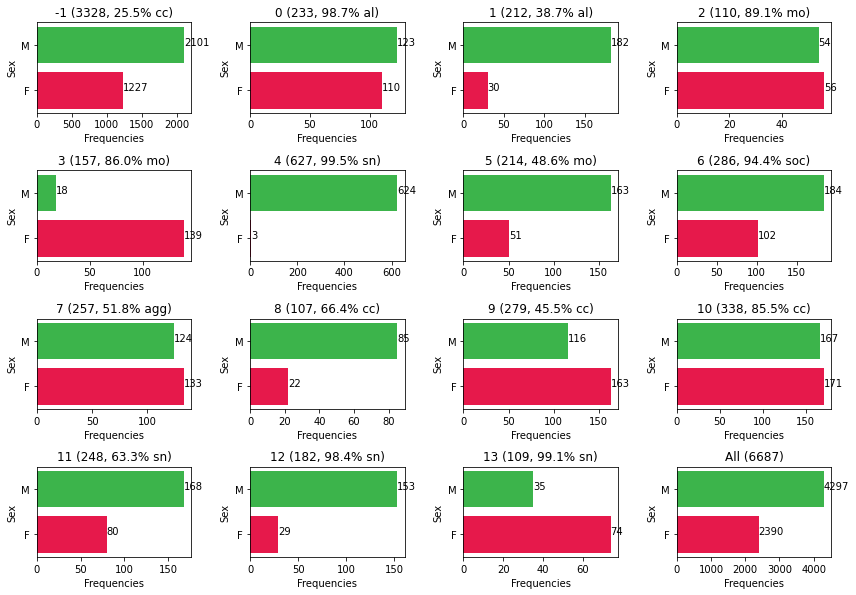

In [ ]:
var = 'status'
var = 'Sex'
#var = 'date'
#var = 'indv'
#var = 'soundfoc_yn'
group_var = 'call_lable'
group_var = 'HDBSCAN'

#var_levels = sorted(list(set(umap_df[var])))
#group_var_levels =  sorted(list(set(umap_df[group_var])))
truth = 'call_lable'

#plt.figure(figsize=(10, 20))
plt.figure(figsize=(12, 10))

my_df = umap_df.loc[umap_df[var]!='NA']
#my_df = my_df.loc[my_df[group_var]!=-1] # for HDBSCAN
var_levels = sorted(list(set(my_df[var])))
group_var_levels =  sorted(list(set(my_df[group_var])))

for i,group_var_level in enumerate(group_var_levels,1):
    #plt.subplot(5, 3, i)
    plt.subplot(5, 4, i)
    sub_df = my_df.loc[my_df[group_var]==group_var_level]

    labelcounts = pd.DataFrame(sub_df[var].value_counts())

    for level in var_levels:
      if (not level in labelcounts.index):
        row = pd.Series({var:0},name=level)
        labelcounts = labelcounts.append(row)


    labelcounts.sort_index(inplace=True)
    pal = sns.color_palette(distinct_20, n_colors=len(labelcounts.index))  
    #pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
    plt.barh(labelcounts.index, labelcounts[var].values, color = pal)

    for index, value in enumerate(labelcounts[var].values):
      plt.text(value, index, str(value))
    title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
    if group_var!=truth:
      title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
    plt.title(title)
    plt.ylabel(var)
    plt.xlabel('Frequencies')

# Add plot for all
#plt.subplot(5, 3, i+1)
plt.subplot(5, 4, i+1)
sub_df = my_df

#labelcounts = pd.DataFrame(sub_df[var].value_counts())
labelcounts = pd.DataFrame(umap_df[var].value_counts())
labelcounts.sort_index(inplace=True)

plt.barh(labelcounts.index, labelcounts[var].values, color = pal)

for index, value in enumerate(labelcounts[var].values):
  plt.text(value, index, str(value))

#title='All ('+str(my_df.shape[0])+")"
title='All ('+str(umap_df.shape[0])+")"
plt.title(title)
plt.ylabel(var)
plt.xlabel('Frequencies')

plt.tight_layout()
plt.savefig(FIGURES+'cluster_analysis_'+group_var+'_'+var+'.png')

In [ ]:
2382/6687

0.35621354867653654

In [ ]:
sorted(list(set(umap_df['date'])))

['2017-08-03',
 '2017-08-06',
 '2017-08-07',
 '2017-08-23',
 '2017-08-24',
 '2017-08-25',
 '2017-09-03',
 '2017-09-04',
 '2017-09-05',
 '2019-07-12',
 '2019-07-13',
 '2019-07-14',
 '2019-07-15',
 '2019-07-16',
 '2019-07-17']

#### Continuous variables

Figure that shows distribution of **continuous** variables in different groups.
Set groups and variable of interest with 
- group_var = [name_of_grouping_variable] 
- var [continuous_variable_of_interest]


In [ ]:
var = 'duration_s'
group_var = 'call_lable'
group_var = 'Aggl_Euclid'

group_var_levels =  sorted(list(set(umap_df[group_var])))

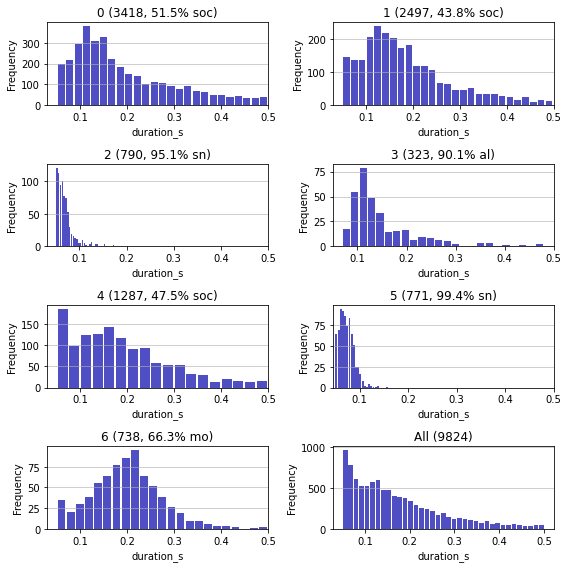

In [ ]:
plt.figure(figsize=(8, 8))

xmax = np.max(umap_df[var].values)

for i,group_var_level in enumerate(group_var_levels,1):
    plt.subplot(4, 2, i)
    sub_df = umap_df.loc[umap_df[group_var]==group_var_level]

    n, bins, patches = plt.hist(x=sub_df[var], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)

    title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
    if group_var!=truth:
      title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
 
    plt.xlim(xmax=xmax)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel(var)

# Add plot for al
plt.subplot(4, 2, i+1)
sub_df = umap_df

n, bins, patches = plt.hist(x=sub_df[var], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

title = 'All ('+str(sub_df.shape[0])+")"
plt.title(title)
plt.ylabel('Frequency')
plt.xlabel(var)

plt.tight_layout()

### Overrepresentation

#### Categorical variables

In [ ]:
var = 'status'
#var = 'Sex'
#var = 'soundfoc_yn'
group_var = 'call_lable'
#group_var = 'Aggl_Euclid'
group_var = 'HDBSCAN'
truth = 'call_lable'

In [ ]:
umap_df.head(2)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n


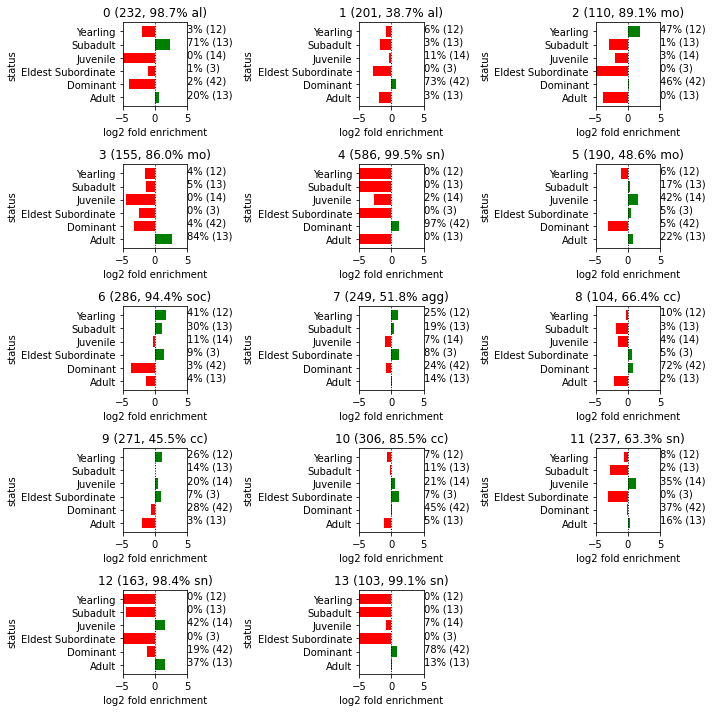

In [ ]:
plt.figure(figsize=(10, 10))

# Remove NA
my_df = umap_df.loc[umap_df[var]!='NA']
my_df = my_df.loc[umap_df[group_var]!=-1]
var_levels = sorted(list(set(my_df[var])))
group_var_levels =  sorted(list(set(my_df[group_var])))

labelcounts_all = pd.DataFrame(my_df[var].value_counts(normalize=True))
labelcounts_all.sort_index(inplace=True)

for i,group_var_level in enumerate(group_var_levels,1):
  plt.subplot(5, 3, i)
  sub_df = my_df.loc[my_df[group_var]==group_var_level]
  

  labelcounts = pd.DataFrame(sub_df[var].value_counts(normalize=True))

  missing_level = []

  for i,level in enumerate(var_levels):
    if (not level in labelcounts.index):
      missing_level.append(True)
      row = pd.Series({var:100/(sub_df.shape[0])},name=level) # equi to 1 meerkat
      row = pd.Series({var:1},name=level)
      labelcounts = labelcounts.append(row)
    else:
      missing_level.append(False)
  
  labelcounts.sort_index(inplace=True)
  #pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
  y = np.log2(labelcounts[var].values/labelcounts_all[var].values)
  # log of 0 problem! thus, set missing levels to % equivalent to 1 meerkat
  
  c = ["red" if x<=0 else "green" for x in y]
  xmin = -5
  xmax = 5
  for i,missing in enumerate(missing_level):
    if(missing):
      c[i] = "red"
      y[i] = xmin
      labelcounts.iloc[i,0] = 0


  plt.barh(labelcounts.index, y, color = c)
  #plt.barh(labelcounts.index, y, color = pal)
  #plt.bar(labelcounts.index, y, color = pal)
  plt.axvline(x=0, color="black", linewidth=1,linestyle=':')


  for index, (value1,value2,y) in enumerate(zip(labelcounts[var].values, labelcounts_all[var].values,y)):
     #plt.text(y, index, (str(round(value1*100,1))+"% ("+str(round(value2*100,1))+"%)"))
     plt.text(xmax, index, (str(int(value1*100))+"% ("+str(int(value2*100))+")"))

  title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
  if group_var!=truth:
    title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
  plt.title(title)
  
  plt.ylabel(var)
  plt.xlabel('log2 fold enrichment')
  plt.xlim(-5,5)

plt.tight_layout()

# Example specs

Example spectrograms for all clusters

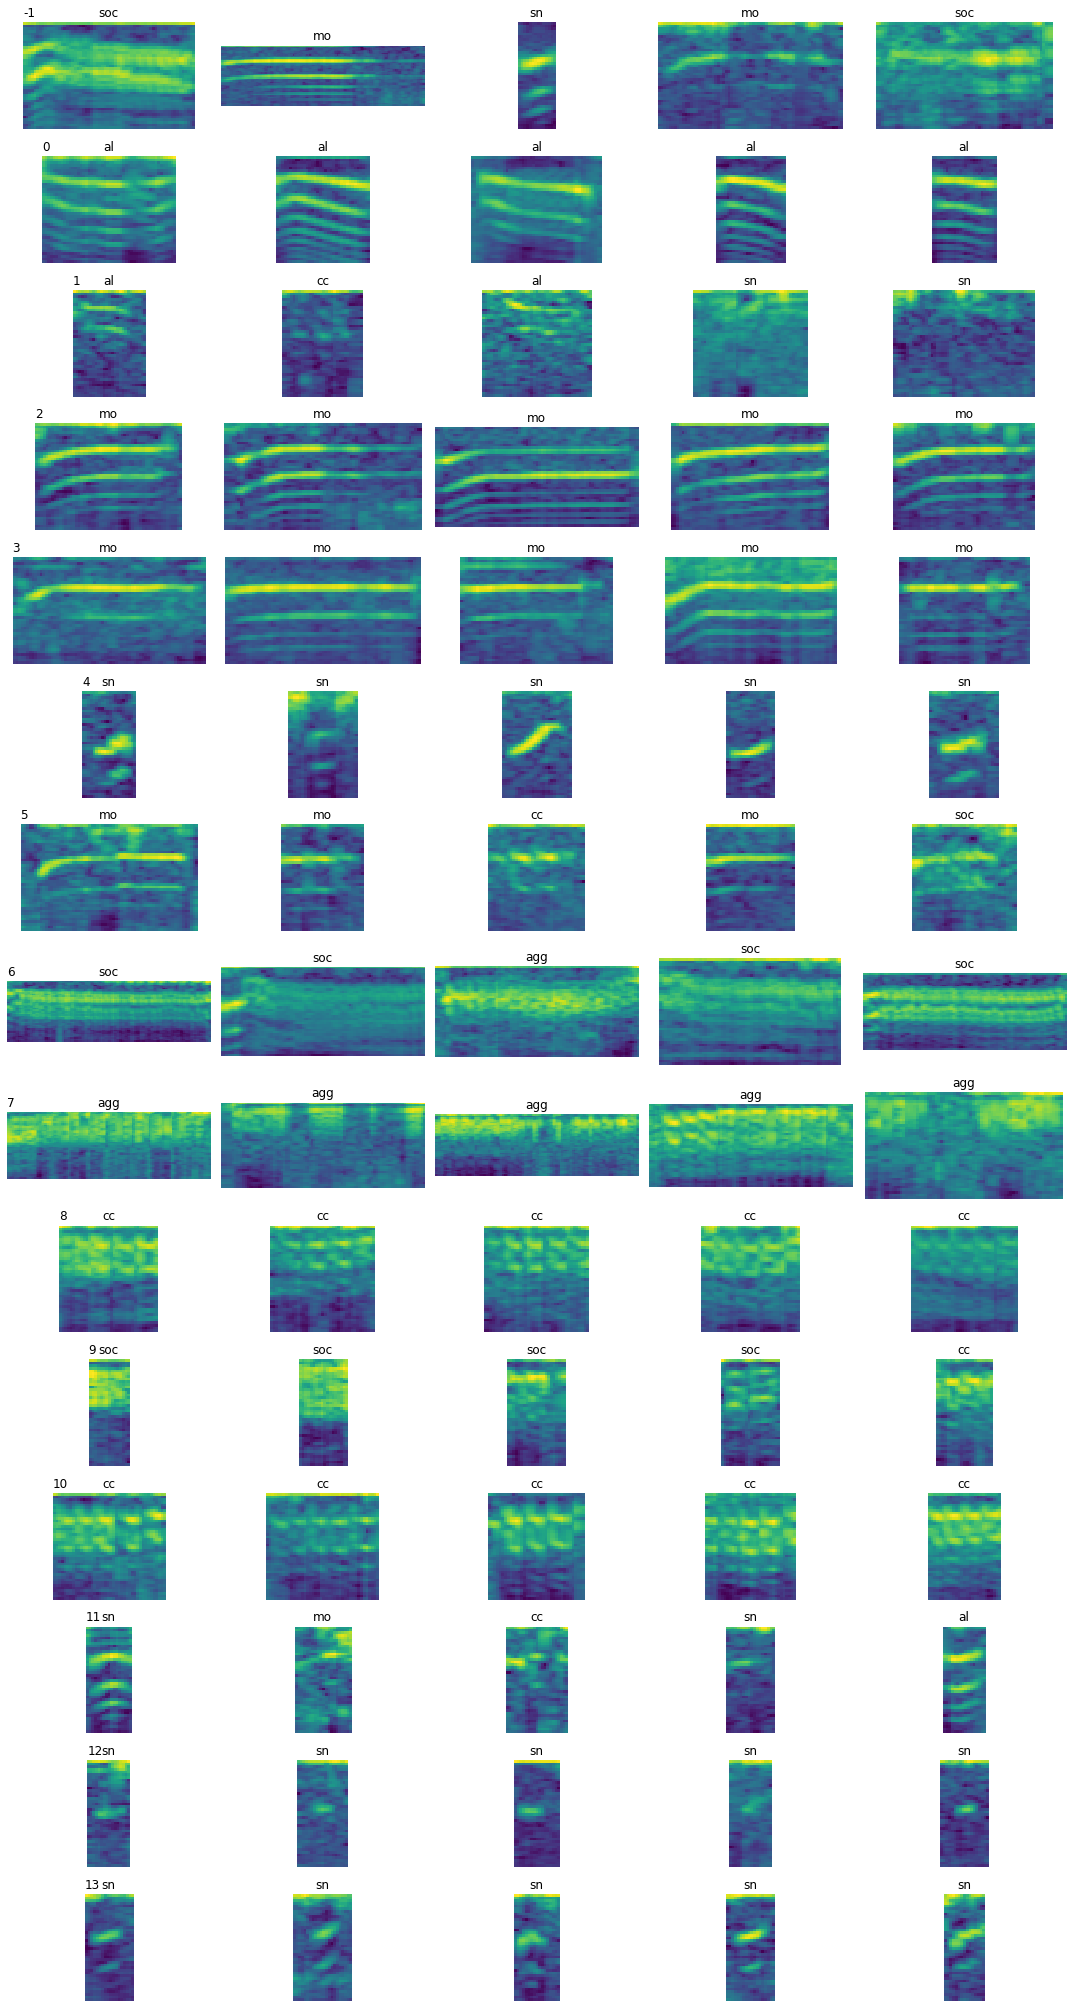

In [ ]:
n_specs=5
specs = {}
  
plt.figure(figsize=(15, 28))

clusters = sorted(list(set(umap_df.HDBSCAN.values)))
k=1

for cluster in clusters:
    example = umap_df[umap_df['HDBSCAN']==cluster].sample(n = n_specs, random_state=2204)
    specs = example['denoised_spectrograms'].values
    labels = example['call_lable'].values
    i=0 
    for spec, label in zip(specs, labels):
        plt.subplot(len(clusters), n_specs, k)
        plt.imshow(spec, interpolation='nearest', aspect='equal')
        plt.axis('off')
        if i==0:     
            title = str(cluster)
            plt.title(title, loc='left')
            title = str(label)
            plt.title(title)
        else:
            title = str(label)
            plt.title(title)
    
    #title = str(cluster)+" ("+str(label)+")"
    #title = str(label)
        k += 1
        i+=1
plt.tight_layout()
plt.savefig(os.path.join(os.path.sep(FIGURES,'HDBSCAN_cluster_examples.png'))